In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve as convolveim
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

## PART A - Harris detector

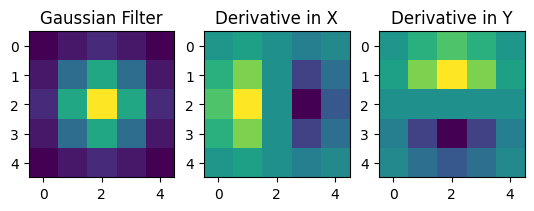

In [2]:
def gauss(size, sigma):
    """
    This function will generate 3 filters given the size of the filter and sigma of Gaussian:
    1: gaussian filter;
    2: derivative of gaussian filters in x and y direction.
    """
    # define the x range
    x_ax = np.arange(0,size) - size/2 + 0.5

    ################################################ TODO ###############################################
    # make 1D gaussian filter
    gauss = (1/sigma) * np.exp(-0.5 * ((x_ax/sigma)**2))
    # Compose 2D Gaussian filter from 1D, using the separability property of 2D Gaussian
    gauss2 = np.dot (gauss[:,None], gauss[None, :])
    # Normalize the filter so that all coefficients sum to 1
    gauss1 = gauss2/np.sum(gauss2)

    # Create derivatives of gaussian
    gauss1_dx = np.matrix(np.zeros((np.shape(gauss1)), dtype="float32"))
    gauss1_dy = np.matrix(np.zeros((np.shape(gauss1)), dtype="float32"))
    for j in range(0, len(x_ax)):
        # derivative filter in x
        gauss1_dx[:, j] = (gauss1[:, j] * (-x_ax[j])/(sigma*sigma)).reshape(size,1)
        ################################################ TODO ###############################################
        # similarly define the difference in y
        gauss1_dy[j, :] = gauss1[j, :] * (-x_ax[j]/(sigma**2))
    return gauss1,gauss1_dx, gauss1_dy

# Visualize the filters you created to make sure you are working with the correct filters
gauss1, gauss1_dx, gauss1_dy = gauss(5, 1)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(gauss1)
plt.title('Gaussian Filter')
plt.subplot(1, 3, 2)
plt.imshow(gauss1_dx)
plt.title('Derivative in X')
plt.subplot(1, 3, 3)
plt.imshow(gauss1_dy)
plt.title('Derivative in Y')
plt.show()

In [73]:
def harris(Ix, Iy , input_image,N):
    """
    The input to this function are the gradient images in x and y directions, the original image and N
    The function will output two arrays/lists x and y which are the N points with largest harris values,
    and an image of the harris values.
    """
    l, m = np.shape(input_image)
    ################################################ TODO ###############################################
    #Forming 3 images
    #Ix square
    Ix2 = Ix**2
    #Iy square
    Iy2 = Iy**2
    #Ix*Iy
    Ixy = Ix*Iy

    # Smooth image Ix2, Iy2, Ixy  with Gaussian filter with sigma=2, size=7.
    # Get the gauss filter for smoothing (reuse what you have)
    gauss_smooth, _, _ = gauss(7,2)
    Ix2_smooth = convolveim(Ix2, gauss_smooth, mode='nearest')
    ################################################ TODO ###############################################
    # CONVOLVE as shown above
    Iy2_smooth = convolveim(Iy2, gauss_smooth, mode='constant')
    Ixy_smooth = convolveim(Ixy, gauss_smooth, mode='constant')
    # By doing this, Ix2_smooth, Iy2_smooth, Ixy_smooth are the three values needed to calculate
    # the A matrix for each pixel.

    ################################################ TODO ###############################################
    # Write code segment to find N harris points in the image
    # Refer to the page 17 of slides on features for the equation
    det = (Ix2_smooth * Iy2_smooth) - (Ixy_smooth**2)
    trace = Ix2_smooth + Iy2_smooth
    H = det - 0.06 * (trace**2)

    ################################################ TODO ###############################################
    # Save a copy of the original harris values before detecting local max
    H0 = H
    # Detect local maximum over 7x7 windows
    local_max_win = 7
    a = int(np.floor(local_max_win/2))
    H = np.pad(H,((a,a),(a,a)), 'constant')
    # Initialize a mask to be all ones. The mask corresponds to the local maximum in H
    H_max = np.ones(H.shape)
    for i in range(a,l+a):
        for j in range(a,m+a):
            # Take a WxW patch centered at point (i,j), check if the center point is larger than all other points
            # in this patch. If it is NOT local max, set H_max[i,j] = 0
            patch = H[i - a:i + a + 1, j - a:j + a + 1]
            if H[i, j] < np.max(patch):
                H_max[i, j] = 0

    # Multiply the mask with H, points that are not local max will become zero
    H = H_max*H
    H = H[a:-a,a:-a]

    # Find largest N points' coordinates
    # Hint: use np.argsort() and np.unravel_index() to sort H and get the index in sorted order
    indices = np.unravel_index(np.argsort(H, axis=None), H.shape)
    x = indices[0][:N]
    y = indices[1][:N]

    # x,y should be arrays/lists of x and y coordinates of the harris points.

    return x,y,H0

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


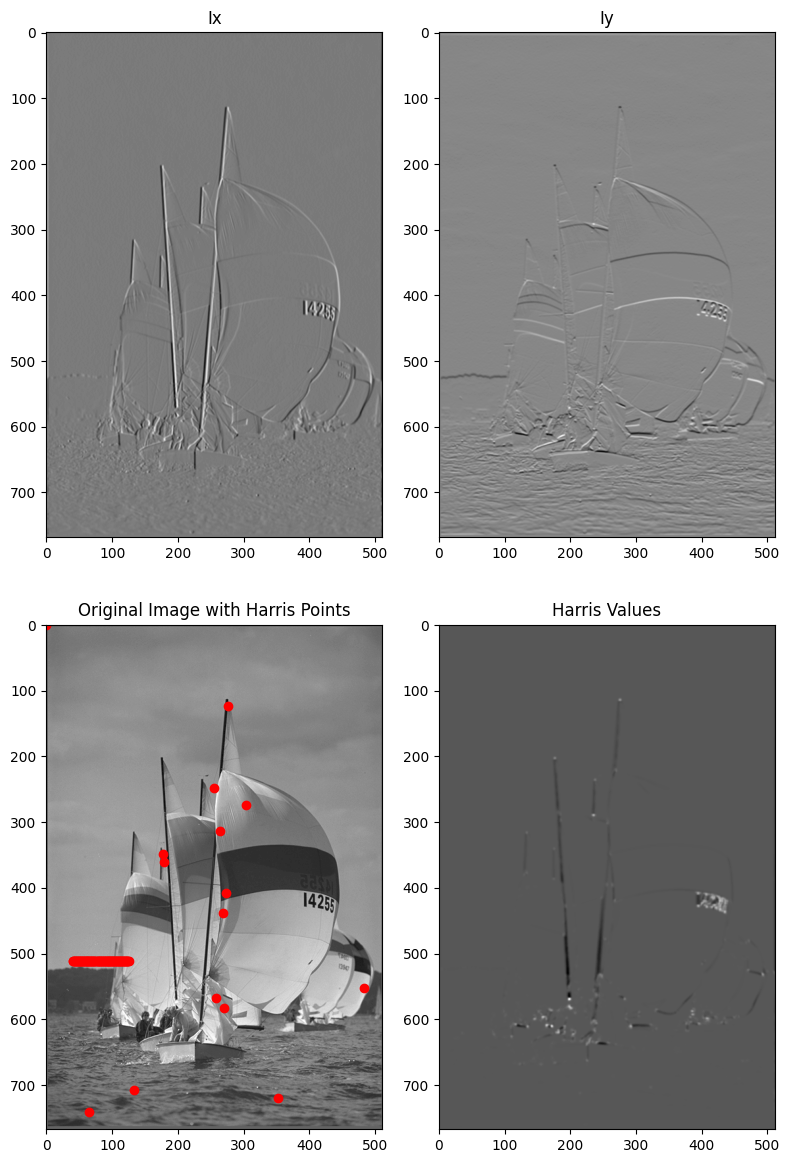

In [70]:
from google.colab import drive
drive.mount('/content/drive/')

##### IMPORTANT: Convert your image to float once you load the image. ######
input_image = cv2.imread('/content/drive/MyDrive/ca5/9.png',0).astype(float)
img = cv2.normalize(input_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

################################################ TODO ###############################################
# Generating the gaussian filter
sigma = 1
size = int(4*sigma + 1)
# Function call to gauss
gauss_filt, gauss_filt_dx, gauss_filt_dy = gauss(size, sigma)


################################################ TODO ###############################################
# Convolving the filter with the image
# Convolve image with dx filter
Ix = convolveim(input_image,gauss_filt_dx,mode ='nearest')
# Convolve image with dy filter
Iy = Iy = convolveim(input_image, gauss_filt_dy)

x,y,H0 = harris(Ix, Iy ,input_image,100)
################################################ TODO ###############################################
# Plot: Ix, Iy, Original image with harris point labeled in red dots, H0 harris value image
# Hint: you may use "plt.plot(y,x, 'ro')"   # Note: x is vertical and y is horizontal in our above definition
                                            # But when plotting the point, the definition is reversed
plt.figure(figsize=(8, 12))

plt.subplot(2, 2, 1)
plt.imshow(Ix, cmap='gray')
plt.title('Ix')

plt.subplot(2, 2, 2)
plt.imshow(Iy, cmap='gray')
plt.title('Iy')

plt.subplot(2, 2, 3)
plt.imshow(input_image, cmap='gray')
plt.plot(y, x, 'ro')
plt.title('Original Image with Harris Points')

plt.subplot(2, 2, 4)
plt.imshow(H0, cmap='gray')
plt.title('Harris Values')

plt.tight_layout()
plt.show()

## PART B - SIFT descriptor

In [21]:
def histo(theta4,mag4):
    """
    theta4: an array of quantized orientations, with values 0,1,2...7.
    mag4: an array of the same size with magnitudes
    """
    temp = np.zeros((1,8),dtype='float32')
    ################################################ TODO ###############################################
    # write code segment to add the magnitudes of all vectors in same orientations
    for i in np.arange(8):
      temp[0][i] = np.sum (mag4[np.where(theta4==i)])

    # temp should be a 1x8 vector, where each value corresponds to an orientation and
    # contains the sum of all gradient magnitude, oriented in that orientation
    return temp

def descriptor(theta16,mag16):
    """
    Given a 16x16 patch of theta and magnitude, generate a (1x128) descriptor
    """
    filt,_,_ = gauss(16,8)
    mag16_filt = mag16*filt

    # array to store the descriptor. Note that in the end descriptor should have size (1, 128)
    desp = np.array([])
    ################################################ TODO ###############################################
    # Make function call to histo, with arguments theta16 and mag16_fil
    # This is used for find the location of maximum theta
    histo16 = histo(theta16, mag16_filt)
    maxloc_theta16 = np.argmax(histo16)

    for i in range(0,16,4):
        for j in range(0,16,4):
            ################################################ TODO ###############################################
            # Use histo function to create histogram of oriantations on 4x4 pathces in the neighbourhood of the harris points
            # You should shift your histogram for each cell so that the dominant orientation of the 16x16 patch becomes the first quantized orientation
            # You should update the variable desp to store all the orientation magnitude sum for each sub region of size 4x4
            theta4 = theta16[i:i+4,j:j+4]
            mag4 = mag16_filt[i:i+4,j:j+4]
            histo4 = histo(theta4, mag4)
            histo4 = np.roll(histo4, maxloc_theta16)
            desp = np.append(desp, histo4)


    ################################################ TODO ###############################################
    # normalize descriptor, clip descriptor, normalize descriptor again
    desp = desp / np.linalg.norm(desp)
    desp = np.clip(desp, 0, 0.2)
    desp = desp / np.linalg.norm(desp)
    desp = np.matrix(desp)

    return desp


In [26]:
def part_B(input_image):

    # Normalize the image
    img = cv2.normalize(input_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Generate derivative of Gaussian filters, using sigma=1, filter window size=4*sigma+1
    sigma = 1
    _, filt_dx, filt_dy = gauss(5, 1)

    ################################################ TODO ###############################################
    # Image convolved with filt_dx and filt_dy
    img_x = convolveim(img, filt_dx)
    img_y = convolveim(img, filt_dy)

    # Calculate magnitude and theta, then quantize theta.
    mag = np.sqrt(img_x ** 2 + img_y ** 2)
    theta = np.arctan2(img_y, img_x)
    theta = (theta/(2*np.pi))*360
    theta = theta*(theta>=0) + (360+theta)*(theta < 0)

    ################################################ TODO ###############################################
    # Quantize theta to 0,1,2,... 7, see instructions above
    q = 45
    N = 8
    theta_q = np.floor(theta / q).astype('uint8')

    ################################################ TODO ###############################################
    # Call harris function to find 100 feature points
    x,y,_ = harris(img_x, img_y, input_image, 100)

    # Pad 15 rows and columns. You will need this extra border to get a patch centered at the feature point
    #    when the feature points lie on the original border of the image.
    theta_q = cv2.copyMakeBorder(theta_q.astype('uint8'), 7,8,7,8, cv2.BORDER_REFLECT)
    ################################################ TODO ###############################################
    mag =  cv2.copyMakeBorder(mag, 7,8,7,8, cv2.BORDER_REFLECT)# similarly add border to the magnitude image
    final_descriptor = np.zeros((1,128))

    for i in range(x.shape[0]):
        # Since you have already added 15 rows and columns, now the new coordinates of the feature points are (x+8, y+8).
        # Then the patch should be [x[i]:x[i]+16,y[i]:y[i]16]
        # Your patch should be centered at the feature point.
        theta_temp = theta_q[x[i]:x[i]+16,y[i]:y[i]+16]
        # similarly, take a 16x16 patch of mag around the point
        mag_temp = mag_temp = mag[x[i]:x[i]+16,y[i]:y[i]+16]
        # function call to descriptors
        temp2 = descriptor(theta_temp, mag_temp)
        final_descriptor = np.vstack((final_descriptor,temp2))

    # Initially, final descriptor has a row of zeros. We are deleting that extra row here.
    final_descriptor = np.delete(final_descriptor,0,0)
    final_descriptor = np.nan_to_num(final_descriptor)
    final_descriptor = np.array(final_descriptor)

    # Combine x,y to form an array of size (Npoints,2) each row correspond to (x,y)
    # You could use np.hstack() or np.vstack()
    final_points = np.vstack((x+8, y+8)).T

    return final_descriptor,final_points


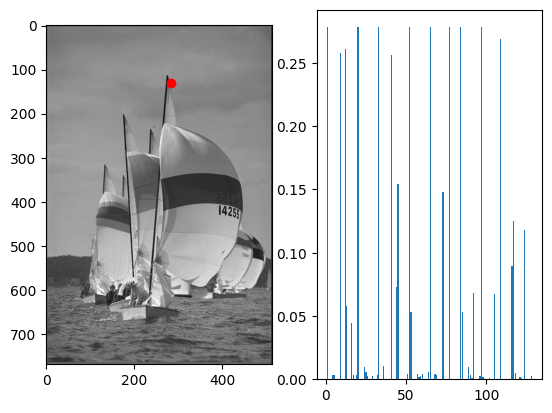

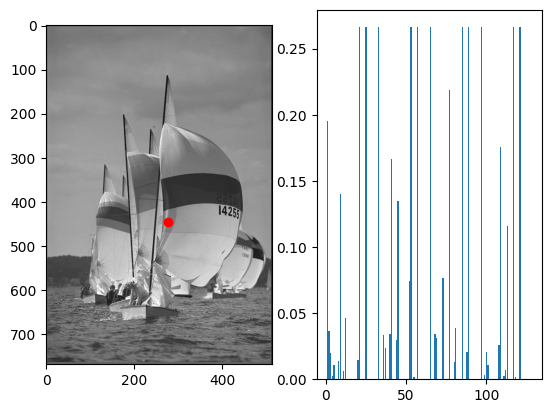

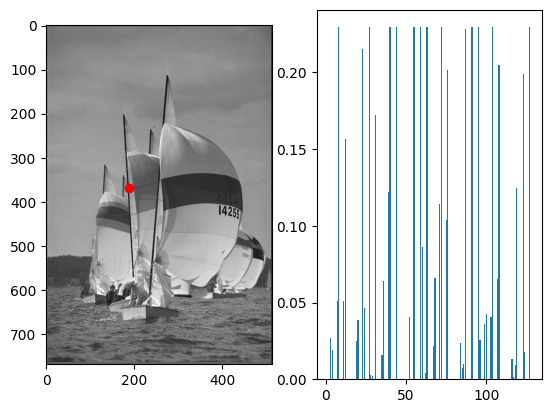

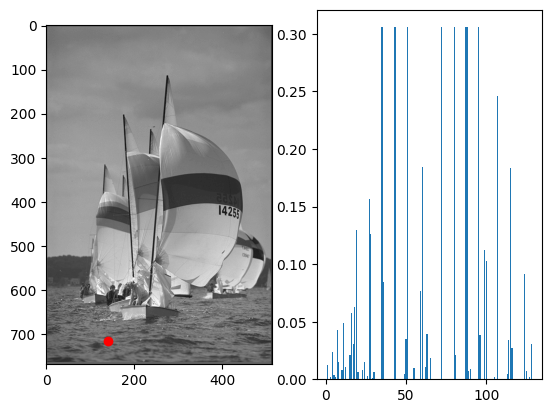

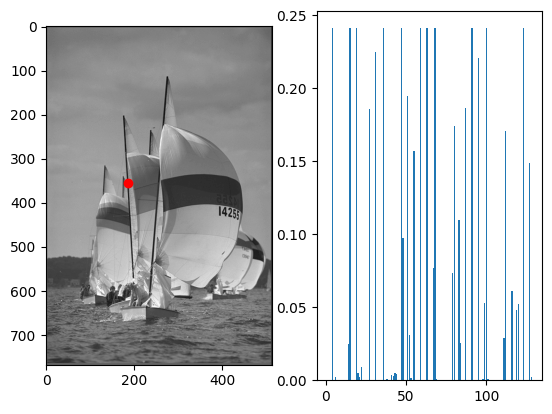

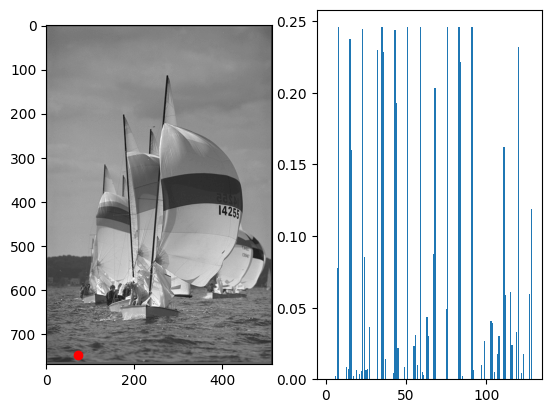

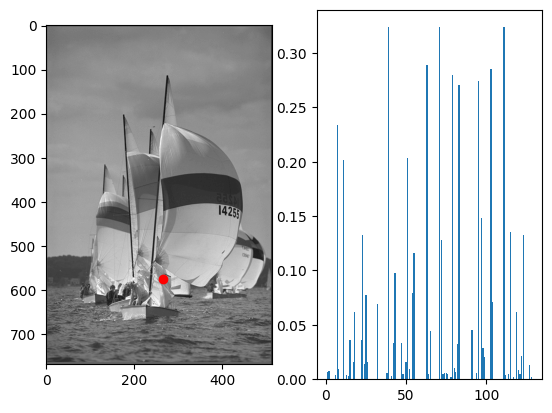

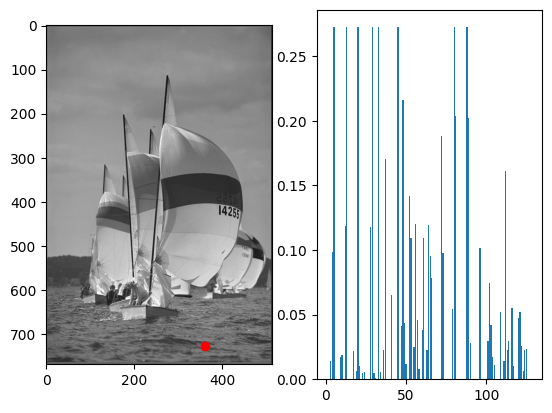

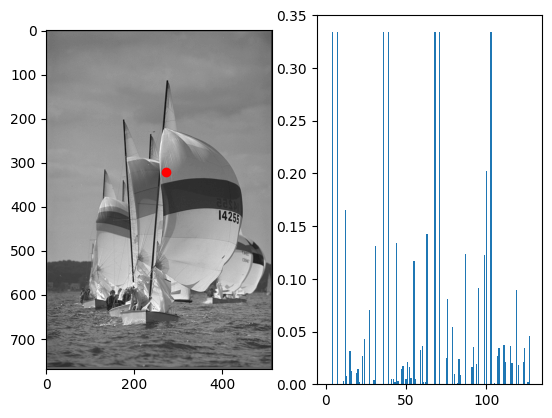

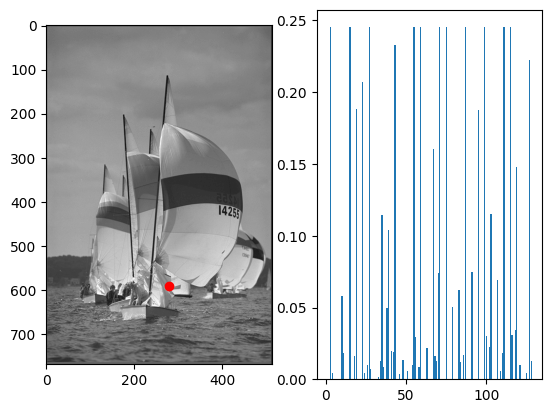

In [37]:
input_image = cv2.imread('/content/drive/MyDrive/ca5/9.png',0).astype(float) # input image


# Visualization the results. Plot the feature point similiar to Part1 and plot SIFT features as bar
final_descriptor , final_points = part_B(input_image)

for i in range(0,10):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(input_image,cmap='gray')
    ax1.autoscale(False)
    ax1.plot(final_points[i][1],final_points[i][0], 'ro')
    ax2.bar(np.arange(1,129),final_descriptor[i,:])
    plt.show()

